<center><h1>Ablation Experiments</h1></center>

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd
from torchaudio.functional import mu_law_encoding, mu_law_decoding
from scipy.io import wavfile
import os

# Custom modules
from sashimi import *
from wav_dataset import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

In [4]:
model_folder = "./models/ym-2l"

# Full Dataset Training

We trained the model using `train_sc09.py` script. The following code block will print the train and validation loss.

- AdamW optimizer was used with a learning rate of 0.001.
- Starting at epoch 111, the learning rate was reduced to 0.0002.

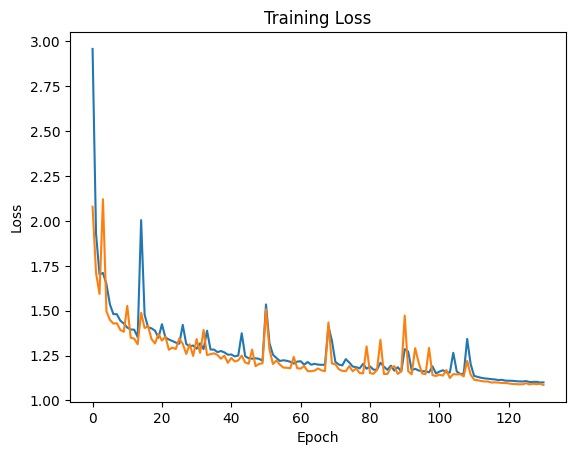

In [5]:
with open(os.path.join(model_folder, "train_loss.txt"), 'r') as f:
    train = [float(i.strip()) for i in f.readlines()]

with open(os.path.join(model_folder, "validation_loss.txt"), 'r') as f:
    valid = [float(i.strip()) for i in f.readlines()]

plt.title(label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train)
plt.plot(valid)

# Loading the Pre-Trained Model

Let's load the pre-trained model. Note that you should have downloaded this model using `download_data.sh`.
Note that there are other pre-trained models in `models` folder.

In [6]:
epoch = len(train)
checkpoint_filename = os.path.join(model_folder, f"epoch{epoch:04d}.pt")
print("Loading model:", checkpoint_filename)
checkpoint = torch.load(checkpoint_filename, map_location=device)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000*8,
    block_count=2,
    encoder=Embedding(256, 64),
).to(device)

model.load_state_dict(checkpoint["model_state"])

Loading model: ../models/ym-2l/epoch0131.pt


<All keys matched successfully>

The following code block will generate 32 samples at once and save them.

In [7]:
seed = 42
torch.manual_seed(seed)
model.eval()
with torch.no_grad():
    gen = generate_audio_sample(model, 8*16000, batch_size=32)
    gen = mu_law_decoding(gen, 256).cpu()

for i, g in enumerate(gen):
    wavfile.write(f"outputs/ym-2l/epoch{epoch:04d}-seed{seed}-{i}.wav", 16000, g.numpy())

  0%|          | 0/128000 [00:00<?, ?it/s]

Let's listen to the generated samples.

In [8]:
selected_index = 0

In [ ]:
# You can run this block repeatedly to switch to the next sample
selected = gen[selected_index]
print("Sample", selected_index)
selected_index = (selected_index + 1) % gen.size(dim=0)
plt.figure()
plt.plot(selected)
ipd.Audio(selected.numpy(), rate=16000)

# Reproducing the Results

## NLL Test

Next, we will compute negative log likelihood (NLL) values on the test dataset.

In [8]:
test_dataset = YoutubeMixDataset("./datasets/youtube-mix/test", duration=8, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_dataset)

111

Note that [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) simply calculates the NLL by applying softmax internally:

$$
l_n = - \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
$$

Note that PyTorch uses natural log by default. We convert this to NLL in bits by dividing the result by $\log(2)$. 

In [9]:
model.eval()
criterion = torch.nn.CrossEntropyLoss()
with torch.no_grad():
    nll = 0.0
    for x, y in tqdm(test_dataloader, leave=False):
        y_hat = model(x)
        nll += criterion(y_hat.view(-1, 256), y.view(-1))
    nll /= len(test_dataloader)

    print("Average NLL:", nll.item())
    print("Average NLL in base 2:", (nll / torch.tensor(2.0).log()).item())
    print("Average NLL converted to probability:", (-nll).exp().item())

  0%|          | 0/111 [00:00<?, ?it/s]

Average NLL: 1.0999635457992554
Average NLL in base 2: 1.586911916732788
Average NLL converted to probability: 0.33288320899009705


Our test NLL in bits is worse than the values reported in the paper.